# Making LoL_Win_Predict_Big Static

# Purpose of This Project
## Background
This is my first coding project and its purpose is simply to practice some of the concepts I have learned on Codecademy. My academic background is a BASc in Nanotechnology Engineering, where the limited amount of programming done was computational. I learned near the end of my degree that I enjoyed computer science and specifically wanted to spend some time learning the basics/fundamentals of data science and machine learning.

## League of Legends
To keep me motivated and interested, I decided to work with real-world data that I personally have an interest in.

League of Legends (LoL) is a highly popular multiplayer online battle arena (MOBA) video game developed and published by Riot Games. In LoL, players assume the role of a "champion," each with unique abilities, and compete in teams to destroy the opposing team's base while defending their own.

There are many reasons why League of Legends makes a good data science project:

Vast Amount of Data: League of Legends generates an enormous amount of data every day, including gameplay statistics, match results. This data can be collected from the game's API, online repositories, or directly from the game itself.

Complexity: The game is highly complex, with numerous variables influencing the outcome of matches. These variables include champion picks, item builds, player skill levels, team compositions, and neutral objectives.

Predictive Analytics: With access to historical match data, one can build predictive models to forecast match outcomes, player performance, or even trends in the meta (the most effective strategies and champion picks at a given time).

## Riot API
All the data used in this project was extracted from Riot APIs and stored in a parquet file. There are a few reasons as to why I did this:

First, when requesting data from their APIs, it requires the use of my personal API key tied to my Riot Games account. This key should not be shared with the public and would required some (potentially non-existant) method that I have not currently looked into to keep it hidden and the code still publicly accessible.

Second, this project uses player match histories to attempt to predit the outcome of the game. This dataset changes every time a request is made, making it diffcult to have reproducible results when working on the machine learning models.

Third, there is a limit to the amount of requests that can be made every minute so gathering the data for a larger dataset takes a long time. For example, the models in this project are trained on 500 matches, totalling over 500 requests, which takes over 10 minutes to accomplish.

More information on how the data was collected can be found in the following sections of LoL_Win_Predict_Big.ipynb:
1. Get user PUUID using their Riot ID and Tagline
2. Get user match history (past 50 games)
3. Get match information
4. Extract desired user stats for every match using their PUUID

## Required Libraries
- pyarrow
- pandas
- seaborn
- matplotlib
- numpy
- sklearn
- scipy
- dtale (used but optional - easier DataFrame viewing in Jupyter Notebook)

In [1]:
# Importing required libraries
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dtale

# ML related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency

## Using static DataFrame to no longer need Riot API key
The file imported was generated in LoL_Win_Predict_Big.ipynb. Using a static dataframe makes testing more consistent and removes the need to request data from Riot Games, removing the need of my personal API key (which should not be shared with the public).

More information on how the data was collected can be found there in the following sections of LoL_Win_Predict_Big.ipynb:

1. Get user PUUID using their Riot ID and Tagline
2. Get user match history (past 50 games)
3. Get match information
4. Extract desired user stats for every match using their PUUID

Edit 2024/03/20:

I decided to add the results from the blue team and the red team giving a total of 1000 samples. I was previously only using the results from the blue team because the features being used reflected the results for both teams. For example, if the blue team gets the first kill (value of True in the table), the values must be Flase for the red team. Now however, I have inlcuded new features such as number of dragon kills (as dummy variables), which makes it such that the results of the blue team's objectives is not perfectly reflected in the red team's, creating new and useful data to train on.

In [2]:
# Specify the path to your Parquet file with gzip compression
file_path = 'objectives_data.parquet.gzip'

# Read the Parquet file
table = pq.read_table(file_path)

# Convert the table to a Pandas DataFrame if needed
objectives_data = table.to_pandas()

# Keep only boolean variables
objectives_data = objectives_data.select_dtypes(include='bool')

# Look at the Data

In [3]:
# View DataFrame
#dtale.show(objectives_data).open_browser()

# Remove features with excess NaNs
objectives_clean = objectives_data.dropna(axis=1)

# Determine which columns were dropped
original_cols = objectives_data.columns
dropped_columns = original_cols.difference(objectives_clean.columns)

# View new DataFrame
#dtale.show(objectives_clean).open_browser()

print(f'Number of columns in objectives_data: {len(objectives_data.columns)}')
print(f'Number of columns in objectives_clean: {len(objectives_clean.columns)}')
print("Dropped columns:", dropped_columns)

# No NaN values in data

Number of columns in objectives_data: 27
Number of columns in objectives_clean: 27
Dropped columns: Index([], dtype='object')


## Separate Features and Target Variable

In [4]:
# Separating X and y
X_data = objectives_clean.drop(columns=['win'])
y_data = objectives_clean['win']

# Display the DataFrames
#dtale.show(X_data).open_browser()
#dtale.show(y_data).open_browser()

## Feature-Target Relationship
### Chi2 Contingency
Viewing the strength of the relationship between features and winning. We can immediately see that hordeKills_2 has no impact on the results and can be removed.

In [5]:
def features_chi2(X_data):
    # Create a contingency table
    chi2_list = []
    pval_list = []

    # Checking the association between each X variable and the target variable
    for col in X_data:
        contingency_table = pd.crosstab(X_data[col], y_data)
        chi2_val, pval, _, _ = chi2_contingency(contingency_table)
        chi2_list.append(chi2_val)
        pval_list.append(pval)

    chi2_df = pd.DataFrame({'feature': X_data.columns, 'chi2': chi2_list, 'pval': pval_list})

    chi2_df = chi2_df.sort_values(by = 'chi2', ascending = False).reset_index(drop=True)
    return chi2_df

chi2_df = features_chi2(X_data)

print(chi2_df)

             feature        chi2           pval
0   inhibitorKills_0  462.401850  1.442814e-102
1     inhibitorFirst  404.481476   5.826224e-90
2         baronFirst  202.349276   6.414782e-46
3         towerFirst  152.187660   5.765163e-35
4   inhibitorKills_2  114.987399   7.919913e-27
5      dragonKills_0   87.822719   7.159191e-21
6      dragonKills_4   76.153997   2.623836e-18
7   inhibitorKills_3   73.550212   9.810839e-18
8   inhibitorKills_1   73.339998   1.091338e-17
9    riftHeraldFirst   64.229649   1.107298e-15
10     championFirst   33.128771   8.625297e-09
11     dragonKills_1   28.169186   1.111603e-07
12     dragonKills_3   17.934962   2.285832e-05
13      hordeKills_6   16.604528   4.604097e-05
14      hordeKills_0   13.756339   2.081173e-04
15        hordeFirst   13.620812   2.236919e-04
16  inhibitorKills_4   12.451968   4.175517e-04
17     dragonKills_5   10.734248   1.051707e-03
18     dragonKills_2   10.706129   1.067812e-03
19       dragonFirst    4.407408   3.578

### Pearson Correlation Heat Map
The first thing I notice in the heat map is that riftHeraldFirst and riftHeraldKills are perfectly collinear; They represent the exact same data. The reson for the collinearity is due to the fact that it used to be possible to kill more than one rift herald in a game, making the features different. However as of 2024/03/20, there is only one rift herald per game, making the first team to kill one be the only team to do so.

I will also investigate the impact of keeping/removing the inhibitorKills_0 feature.

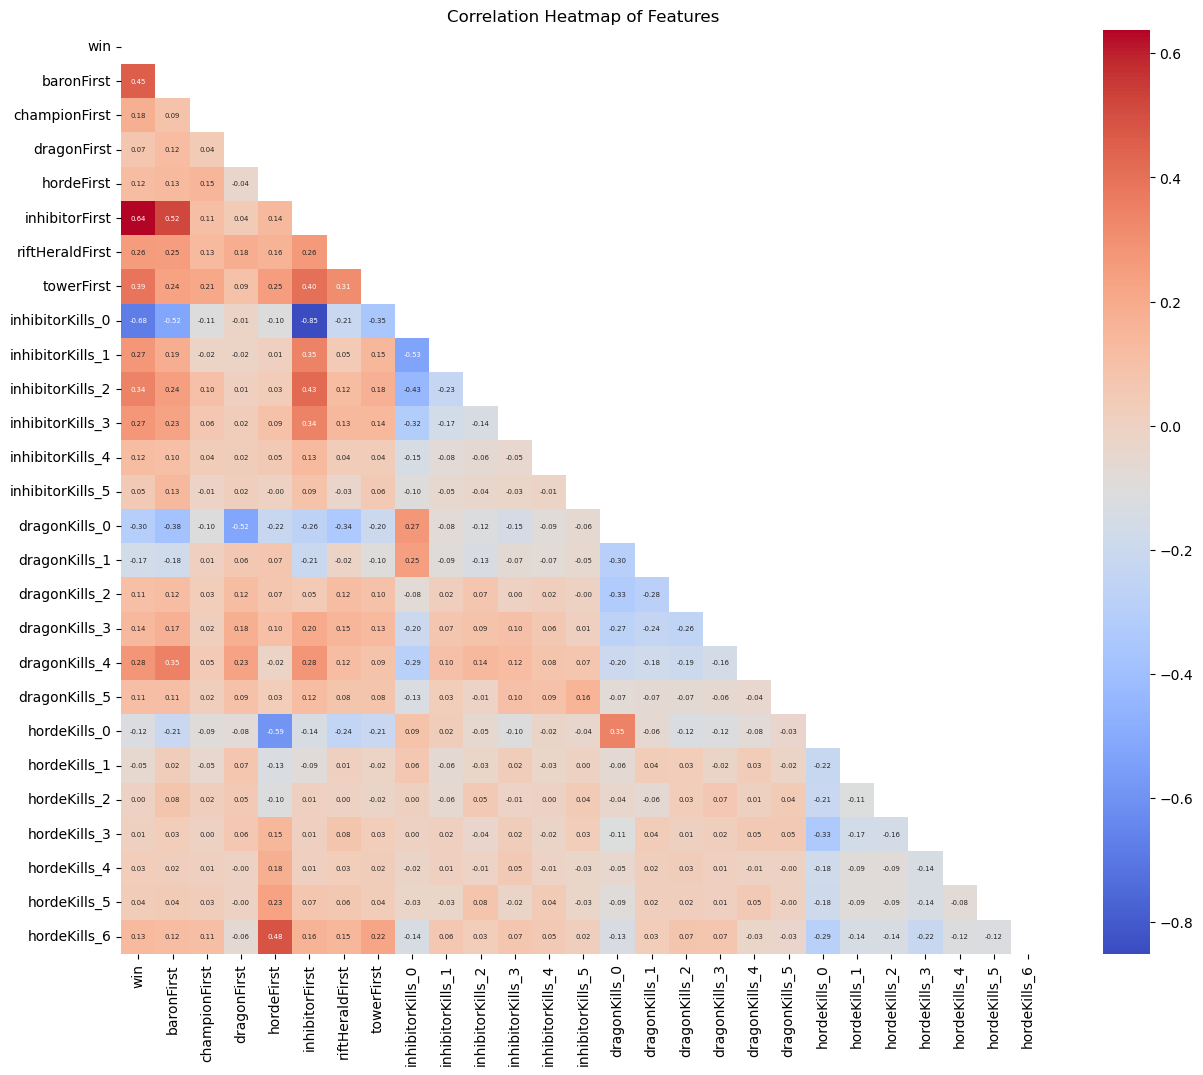

<Figure size 640x480 with 0 Axes>

In [6]:
# Correlation matrix
corr_matrix = objectives_clean.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heat map
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"size": 5})
plt.title('Correlation Heatmap of Features')
plt.show()
plt.clf()

## Check if Feature Trimming is Necessary
We are verifying if removing the features that have a pval greater than 0.05 with relatively low chi2 values will positively impact our model performance. Even though judging the **practical** significance of a feature solely based on its **statistical** significance is ill-advised, in our case it is relatively easy to test the two cases manually and compare the results.

It is worth noting that the significance of these features will likely change with smaller and larger datasets, especially if the dataset uses player matches with a different rank distribution than ours. This is due to the fact that at different skill levels/ranks, the priority, impact, and capability of objectives to carry over to a win can vary drastically. This relationship may be looked into further in a separate project.

In [7]:
# Removing excess features (commented out as it was only used for testing)
#trimmed_cols = chi2_df['feature'].iloc[:-6]
#trimmed_chi2 = chi2_df.iloc[:-1]
X_data.pop('hordeKills_2')

0       True
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: hordeKills_2, Length: 1000, dtype: bool

# Selecting a Machine Learning Model

## Using sklearn machine learning libraries
### Supervised Learning Algorithms

Since the data we are working with is labelled with wins and losses, it makes the most sense to use a supervised learning algorithm.

Models Tested:
- Logistic Regression
- K Nearest Neighbour
- Decision Tree
- Random Forest
- Gradient Boosting

## Machine Learning Model Metrics
Due to the nature of League of Legends, a player's win/loss ratio should be close to 50%, meaning the target variable "win" is well balanced. So, accuracy acts as a simple yet useful indicator of the effectiveness of our machine learning models and will be the primary metric taken into consideration when choosing a model. The win/loss ratio of this dataset, coincidentally, came out to exactly 50% (500/1000).

Confusion Matrix = [[TN, FP], [FN, TP]]

**Accuracy = (TP + TN)/(TP + FP + TN + FN)**

Precision = TP/(TP + FP)

Recall = TP/(TP + FN)

F1 score: weighted average of precision and recall## Model Testing

In [8]:
def model_testing(X_train, X_test, y_train, y_test, model_dict):
    metric_scores_dict = {}
    
    for model_name, model_func in model_dict.items():
        
        print(f'\n#===================== {model_name} =====================#')
        model = model_func()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Create confusion matrix comparing the predicted outcomes to the real outcomes
        confusion_mat = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        print('Confusion Matrix:')
        print(confusion_mat)

        # Accuracy score
        accuracy = accuracy_score(y_test, y_pred)
        metric_scores_dict
        print(f'\nAccuracy Score: {accuracy}')

        # Precision score
        precision = precision_score(y_test, y_pred)
        print(f'Precision Score: {precision}')

        # Recall Score
        recall = recall_score(y_test, y_pred)
        print(f'Recall Score: {recall}')

        # F1 Score
        f1 = f1_score(y_test, y_pred)
        print(f'F1 Score: {f1}')
        
        metric_scores_dict[model_name] = {'tn, fp, fn, tp': [tn, fp, fn, tp],\
                                          'accuracy': accuracy,\
                                          'precision': precision,\
                                          'recall': recall,\
                                          'f1': f1}
        
    metric_scores_pd = pd.DataFrame(metric_scores_dict)
        
    return metric_scores_pd


# Separate into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.25, random_state = 42)

models_dict = {'logisticRegression': LogisticRegression,\
              'kNearestNeighbour': KNeighborsClassifier,\
              'decisionTreeClassifier': DecisionTreeClassifier,\
              'randomForestClassifier': RandomForestClassifier,\
              'gradientBoostingClassifier': GradientBoostingClassifier}    

metric_scores = model_testing(X_train, X_test, y_train, y_test, models_dict)
dtale.show(metric_scores).open_browser()


#===================== logisticRegression =====================#
Confusion Matrix:
[[102  17]
 [ 32  99]]

Accuracy Score: 0.804
Precision Score: 0.853448275862069
Recall Score: 0.7557251908396947
F1 Score: 0.8016194331983806

#===================== kNearestNeighbour =====================#
Confusion Matrix:
[[ 98  21]
 [ 25 106]]

Accuracy Score: 0.816
Precision Score: 0.8346456692913385
Recall Score: 0.8091603053435115
F1 Score: 0.821705426356589

#===================== decisionTreeClassifier =====================#
Confusion Matrix:
[[ 88  31]
 [ 28 103]]

Accuracy Score: 0.764
Precision Score: 0.7686567164179104
Recall Score: 0.7862595419847328
F1 Score: 0.7773584905660378

#===================== randomForestClassifier =====================#
Confusion Matrix:
[[ 93  26]
 [ 21 110]]

Accuracy Score: 0.812
Precision Score: 0.8088235294117647
Recall Score: 0.8396946564885496
F1 Score: 0.8239700374531834

#===================== gradientBoostingClassifier =====================#
Confusion

# Incorporating K-Fold Cross-Validation

This makes it so that every piece of data is used for training and testing and allows us to collect the mean score of every metric across various training/testing fits, making our results more reliable.

Judging by accuracy score, the logistic regressor outperformed the other models and will be our focus going forward.

In [9]:
def k_fold_analysis(X_data, y_data, models_dict, n_folds):
    
    # Extract features and target as NumPy arrays
    X = X_data.values
    y = y_data.values

    # Initialize KFold
    # Use 5 folds to match the 80/20 train/test split of our previous tests
    kf = KFold(n_splits=n_folds)

    # Store score functions in dictionary for easier looping
    metric_functions = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}

    # Will store predicted target variables for each model
    model_pred = {}

    # Dictionary that will summarize all of the scores
    metrics_dict = {}
    
    for model_name in models_dict:
        metrics_dict[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    # Split the data using KFold and train on our models
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train models and store predictions
        for model_name, model_func in models_dict.items():
            # Create model
            model = model_func()
            
            # Fit model
            model.fit(X_train, y_train)

            # Store prediction
            model_pred[model_name] = model.predict(X_test)

        # Add metrics to dictionary
        # Loop through every model name
        for model_name in metrics_dict:

            # Loop through every metric function
            for metric_name in metric_functions:

                # Predicted values for current model
                y_pred = model_pred[model_name]

                # Apply corresponding score function
                score = metric_functions[metric_name](y_test, y_pred)

                # Append score to list for corresponding model and metric
                metrics_dict[model_name][metric_name].append(score)

    metrics_df = pd.DataFrame(metrics_dict)

    # Round the values to 2 decimal points
    metrics_df = metrics_df.applymap(lambda x: [round(num, 2) for num in x])

    # Add the mean of each score for each model
    for model_name in models_dict:
        metrics_df[f'{model_name} Mean'] = metrics_df[model_name].apply(lambda row: np.mean(row))


    return metrics_df


# Number of cross-validation folds
n_folds = 5

metrics = k_fold_analysis(X_data, y_data, models_dict, n_folds)
print(metrics)

                       logisticRegression               kNearestNeighbour  \
accuracy   [0.86, 0.81, 0.86, 0.84, 0.81]  [0.84, 0.82, 0.85, 0.83, 0.82]   
precision  [0.81, 0.83, 0.93, 0.83, 0.84]   [0.82, 0.83, 0.9, 0.83, 0.81]   
recall       [0.93, 0.8, 0.8, 0.82, 0.73]  [0.87, 0.81, 0.82, 0.81, 0.78]   
f1         [0.87, 0.82, 0.86, 0.83, 0.78]   [0.84, 0.82, 0.86, 0.82, 0.8]   

                   decisionTreeClassifier         randomForestClassifier  \
accuracy   [0.77, 0.77, 0.78, 0.78, 0.78]  [0.84, 0.8, 0.86, 0.83, 0.81]   
precision  [0.74, 0.79, 0.89, 0.79, 0.76]  [0.79, 0.8, 0.89, 0.81, 0.79]   
recall       [0.8, 0.77, 0.7, 0.73, 0.76]  [0.91, 0.83, 0.84, 0.84, 0.8]   
f1         [0.77, 0.78, 0.78, 0.76, 0.76]  [0.85, 0.81, 0.86, 0.83, 0.8]   

               gradientBoostingClassifier  logisticRegression Mean  \
accuracy   [0.86, 0.81, 0.86, 0.83, 0.82]                    0.836   
precision  [0.81, 0.81, 0.89, 0.81, 0.79]                    0.848   
recall     [0.93, 0.83,

# Logistic Regressor - Improving Model Performance
## Finding the optimal acceptance threshold using a ROC curve and AUC score
The LogisticRegression class of sklearn has a default acceptance threshold of 0.5. This means that if the model is at least 50% confident in its prediction, it will predict the target to be True (win). I was surprised to learn that there was no built-in parameter to modify the acceptance ratio (to my knowledge) so it had to be done manually.

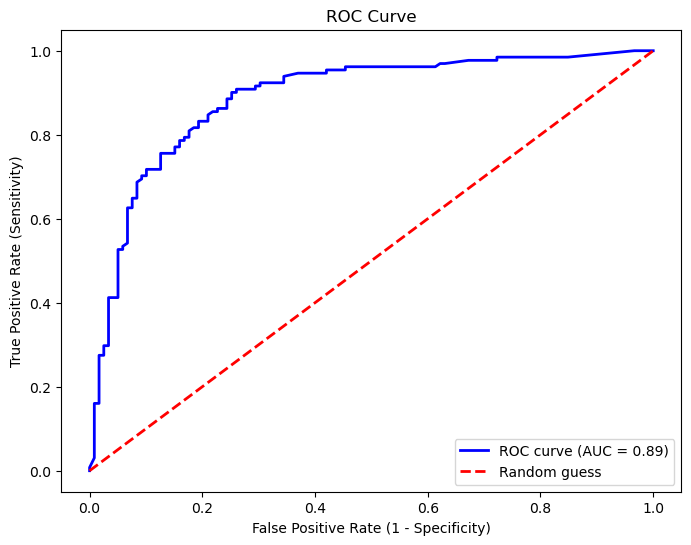

Optimal Threshold (Youden's J): 0.27067007811126076


<Figure size 640x480 with 0 Axes>

In [10]:
def get_optimal_threshold(y_test, y_prob):
    # Compute ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    plt.clf()

    # Calculate Youden's J statistic
    j_statistic = tpr - fpr
    optimal_threshold_index = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_threshold_index]

    print("Optimal Threshold (Youden's J):", optimal_threshold)
    
    return optimal_threshold


# Create logistic regression model
# Needed to increase the max iterations for GridSearchCV
lr = LogisticRegression(max_iter=200)

# Fit training data
lr.fit(X_train, y_train)

# Predict if the game is a win or a loss on the test data
y_pred = lr.predict(X_test)

# Confidence the model has in each of its predictions
y_prob = lr.predict_proba(X_test)[:, 1]

optimal_threshold = get_optimal_threshold(y_test, y_prob)

# Hyperparameter Tuning
Now that we have determined an optimal acceptance threshold, we can tune the hyperparamter C (the inverse of regularization stregth).

In [11]:
def parameter_tuning(model, param_grid, n_folds, scoring, optimal_threshold):

    # Create a grid search object with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring=scoring)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    
    # Confidence model has in each of its predictions
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    y_pred_optimal = (y_pred_prob >= optimal_threshold)

    # Evaluate the model
    accuracy = round(accuracy_score(y_test, y_pred_optimal), 2)
    
    print(f"Best hyperparameters: {best_params}")
    print(f"Accuracy on the test set: {accuracy}")
    
    return best_params, accuracy

# Define hyperparameter grid for grid search
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}

# Call parameter_tuning for our logistic regression model
best_params, accuracy = parameter_tuning(lr, param_grid, n_folds, 'accuracy', optimal_threshold)

Best hyperparameters: {'C': 0.1}
Accuracy on the test set: 0.82


# Test model on new data

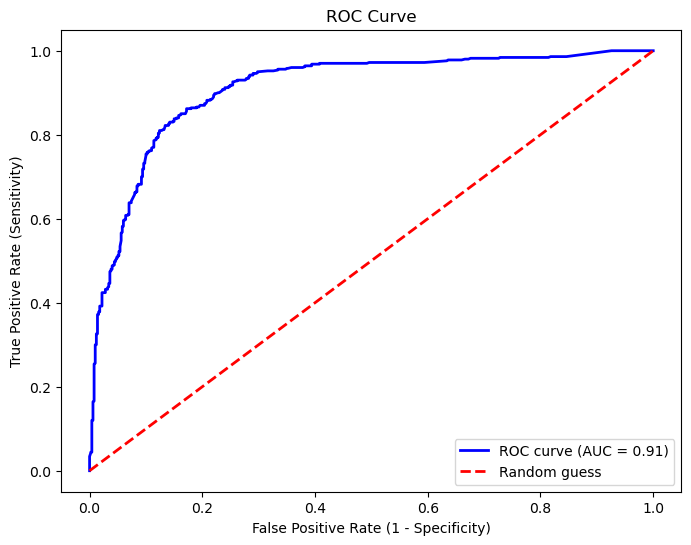

Optimal Threshold (Youden's J): 0.3876757132920743

Accuracy Score: 0.845

Confusion Matrix: [[414  86]
 [ 69 431]]


<Figure size 640x480 with 0 Axes>

In [12]:
# Specify the path to your Parquet file with gzip compression
file_path = 'test_objectives_data.parquet.gzip'

# Read the Parquet file
table = pq.read_table(file_path)

# Convert the table to a Pandas DataFrame
test_objectives_data = table.to_pandas()

# Keep only boolean variables
test_objectives_data = test_objectives_data.select_dtypes(include='bool')

# Remove features with excess NaNs
test_objectives_clean = objectives_data.dropna(axis=1)

# Separating X and y
X_data_test = test_objectives_clean.drop(columns=['win'])
X_data_test.pop('hordeKills_2')
y_data_test = test_objectives_clean['win']

# Fit with optimal C parameter
lr_optimal = LogisticRegression(C = 0.1)
lr_optimal.fit(X_data, y_data)

# Predict on new 1000 game dataset
y_pred = lr_optimal.predict(X_data_test)
y_prob = lr_optimal.predict_proba(X_data_test)[:, 1]

# Find the optimal threshold for new data
optimal_threshold = get_optimal_threshold(y_data_test, y_prob)

y_pred_optimal = (y_prob >= optimal_threshold)

# Accuracy score and confusion matrix
test_accuracy = accuracy_score(y_data_test, y_pred_optimal)
conf_matrix = confusion_matrix(y_data_test, y_pred_optimal)

print(f'\nAccuracy Score: {test_accuracy}')
print(f'\nConfusion Matrix: {conf_matrix}')